In [36]:
import arrow
import json
import pandas as pd
import numpy as np
import requests

%matplotlib inline 
import matplotlib.pyplot as plt

In [37]:
#endpoint = 'http://localhost:8000'
endpoint = 'http://electricitymap-api.tmrow.co'
country_codes = ['DK', 'ES', 'PT']
bounding_boxes = {
    'DK': [
        [13.30324, 57.751949], # NE
        [7.60472, 54.509132], # SW
    ],
    'ES': [
        [4.32788, 43.789959],
        [-9.560789, 36.63546]
    ],
    'PT': [
        [-6.18931, 42.154121],
        [-9.5, 37]
    ]
}
start, end = [
    arrow.get(2016, 11, 19),
    arrow.get(2016, 12, 1)
]
time_span = map(lambda o: o[0], arrow.Arrow.span_range('hour', start, end))

In [38]:
r = requests.session()

In [39]:
def fetch_production(country_code, t):
    url = '%s/v1/production' % endpoint
    params = {
        'countryCode': country_code,
        'datetime': t.to('utc').isoformat()
    }
    obj = r.get(url, params=params).json()
    if not obj: return
    return obj if (t - arrow.get(obj['datetime'])).total_seconds() < 3600 else None
print time_span[0], fetch_production(country_codes[0], time_span[0])

2016-11-19T00:00:00+00:00 {u'countryCode': u'DK', u'datetime': u'2016-11-19T00:00:00.000Z', u'source': u'entsoe.eu', u'production': {u'oil': 11, u'nuclear': None, u'gas': 452, u'biomass': 77, u'coal': 850, u'solar': 0, u'unknown': None, u'wind': 3057, u'hydro': None}, u'_id': u'582fa2c698599dca1a5f603e', u'createdAt': u'2016-11-19T00:54:30.177Z'}


In [40]:
# Fetch all country production data
dates = map(lambda t: pd.Timestamp(t.datetime), time_span)
df_wind = pd.DataFrame(columns=country_codes)
df_solar = pd.DataFrame(columns=country_codes)

for country_code in country_codes:
    print 'Fetching %s..' % country_code
    for t in time_span:
        o = fetch_production(country_code, t)
        if not o: continue
        t = arrow.get(o['datetime']).datetime
        if o.get('production', {}).get('wind', None) is not None:
            df_wind.loc[t, country_code] = o['production']['wind']
        if o.get('production', {}).get('solar', None) is not None:
            df_solar.loc[t, country_code] = o['production']['solar']
df_wind = df_wind.sort_index()
df_solar = df_solar.sort_index()
# TODO: write in a cache

Fetching DK..
Fetching ES..
Fetching PT..


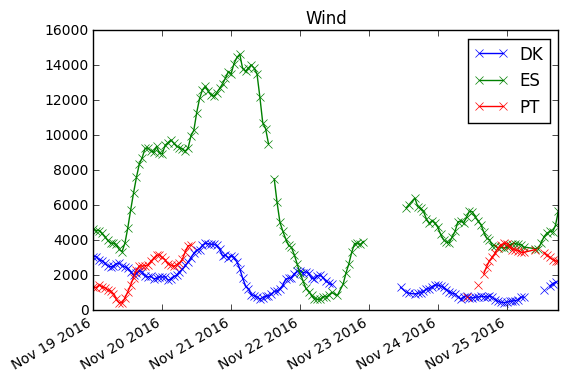

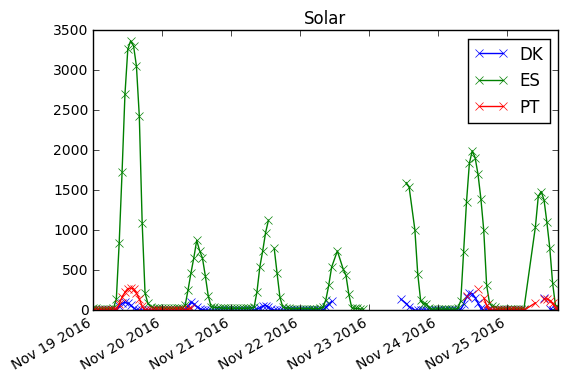

In [41]:
df_wind.plot(marker='x', title='Wind')
df_solar.plot(marker='x', title='Solar')

In [42]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from feeder.parsers import wind, solar

# Force a reload
reload(wind)
reload(solar)

def fetch_best_wind_forecast(t):
    return wind.fetch_wind(r, t, compress=False, useCache=True)
def fetch_best_solar_forecast(t):
    return solar.fetch_solar(r, t, compress=False, useCache=True)

In [43]:
t = time_span[0]
obj = fetch_best_wind_forecast(t)

[10.593441367185642, 13.205502640944799, 14.090227109596212, 7.790924207050149, 4.4381189709154931, 7.1554524664761763, 4.4232680226276138, 5.6772528567961462, 12.351651711410907, 13.392329894383577, 13.517029999226901, 12.250355096894131, 12.609084027002121, 10.228822024065137, 7.4305585254407358, 5.4092236041783304, 5.3858518360608478, 13.259626691577708]


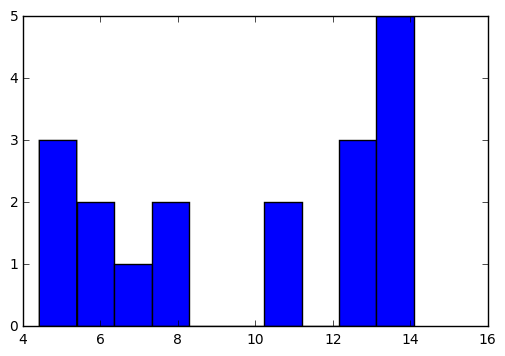

In [44]:
def get_wind_measurements(country_code, t, obj):
    # Return list of wind measurements inside the country

    header_before = obj['forecasts'][0][0]['header']
    header_after  = obj['forecasts'][1][0]['header']
    t_before = arrow.get(header_before['refTime']).replace(hours=+header_before['forecastTime'])
    t_after  = arrow.get( header_after['refTime']).replace(hours=+header_after['forecastTime'])

    grid_origin = [header_before['lo1'], header_before['la1']]
    grid_delta = [header_before['dx'], header_before['dy']]
    grid_n = [header_before['nx'], header_before['ny']]

    dk_temp_data_u = [] # TEMP, will be removeable
    dk_temp_data_v = [] # TEMP, will be removeable
    lons = [] # TEMP, will be removeable
    lats = [] # TEMP, will be removeable
    speeds = []
    bb = bounding_boxes[country_code]

    for i in range(grid_n[0]):
        for j in range(grid_n[1]):
            lon = grid_origin[0] + i * grid_delta[0]
            if lon > 180: lon -= 360
            lat = grid_origin[1] - j * grid_delta[1]
            p = j * grid_n[0] + i
            if lon <= bb[0][0] and lat <= bb[0][1] and \
                lon >= bb[1][0] and lat >= bb[1][1]:
                # We're in the box!
                x = (t.timestamp - t_before.timestamp)/(t_after.timestamp - t_before.timestamp)
                if abs(x) > 1: raise Exception('t is outside of bounds!')
                u = obj['forecasts'][0][0]['data'][p] * (1-x) + obj['forecasts'][1][0]['data'][p] * x
                v = obj['forecasts'][0][1]['data'][p] * (1-x) + obj['forecasts'][1][1]['data'][p] * x
                lons.append(lon)
                lats.append(lat)
                dk_temp_data_u.append(u)
                dk_temp_data_v.append(v)

                speeds.append(np.sqrt(u*u + v*v))

    #plt.figure(figsize=(10,10))
    #plt.quiver(lons, lats, dk_temp_data_u, dk_temp_data_v)
    #plt.axis('equal');
    
    return speeds

s = get_wind_measurements('DK', arrow.get(t), fetch_best_wind_forecast(t))
print s
plt.figure()
plt.hist(s);

[33.0, 30.0, 36.0, 58.0, 110.0, 123.0, 146.0, 176.0, 263.0, 294.0, 312.0, 313.0, 310.0, 287.0, 303.0, 351.0, 405.0, 422.0, 481.0, 485.0, 497.0, 492.0, 470.0, 476.0]


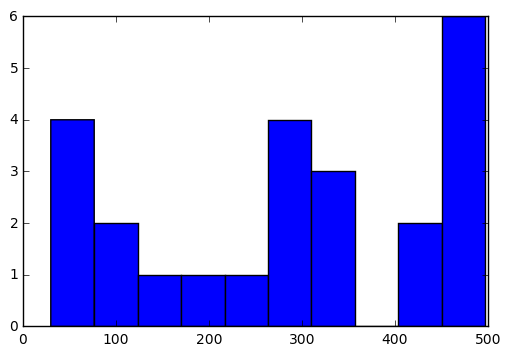

In [52]:
def get_solar_measurements(country_code, t, obj):
    # Return list of wind measurements inside the country

    t_before = arrow.get(obj['forecasts'][0]['horizon'])
    t_after  = arrow.get(obj['forecasts'][1]['horizon'])

    grid_n = [len(obj['forecasts'][0]['DSWRF']), len(obj['forecasts'][0]['DSWRF'][0])]

    lons = [] # TEMP, will be removeable
    lats = [] # TEMP, will be removeable
    intensities = []
    bb = bounding_boxes[country_code]

    for i in range(grid_n[0]):
        for j in range(grid_n[1]):
            p = i * grid_n[1] + j
            lon = obj['forecasts'][0]['lonlats'][0][p]
            if lon > 180: lon -= 360
            lat = obj['forecasts'][0]['lonlats'][1][p]
            if lon <= bb[0][0] and lat <= bb[0][1] and \
                lon >= bb[1][0] and lat >= bb[1][1]:
                # We're in the box!
                x = (t.timestamp - t_before.timestamp)/(t_after.timestamp - t_before.timestamp)
                if abs(x) > 1: raise Exception('t is outside of bounds!')
                v = obj['forecasts'][0]['DSWRF'][i][j] * (1-x) + obj['forecasts'][1]['DSWRF'][i][j] * x
                lons.append(lon)
                lats.append(lat)

                intensities.append(v)

    return intensities

t = arrow.get(2016,11,24,12,0,0)
s = get_solar_measurements('PT', arrow.get(t), fetch_best_solar_forecast(t))
print s
plt.figure()
plt.hist(s);

Fetching forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Fetching forecast of 2016-11-25T21:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T21:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Done
Fetching forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Fetching forecast of 2016-11-25T21:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T21:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Done
Fetching forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Fetching forecast of 2016-11-25T21:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch 

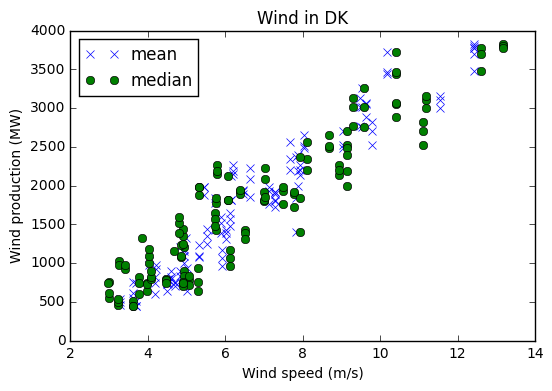

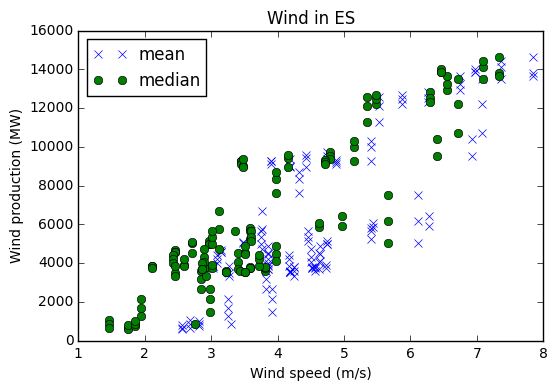

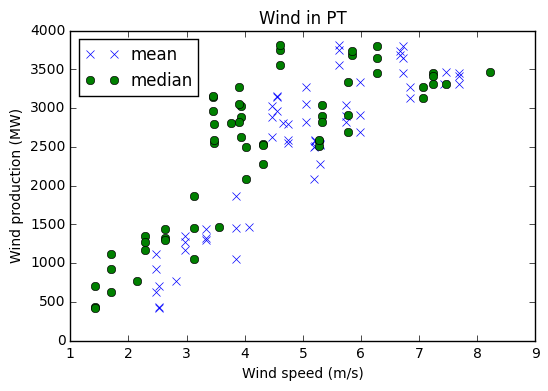

In [55]:
for country_code in country_codes:
    ws_means = []
    ws_medians = []
    ws_maxs = []
    ws_mins = []
    for i in range(len(df_wind)):
        t = arrow.get(df_wind.index[i])
        w_fcast = fetch_best_wind_forecast(t)
        if not w_fcast: 
            print 'Skipping forecast at %s' % t
            continue
        ws = get_wind_measurements(country_code, t, w_fcast)
        ws_means.append(np.mean(ws))
        ws_medians.append(np.median(ws))
        ws_maxs.append(np.max(ws))
        ws_mins.append(np.min(ws))
        
    plt.figure()
    wind_prod = df_wind.loc[:, country_code]
    plt.plot(ws_means, wind_prod, 'x')
    plt.plot(ws_medians, wind_prod, 'o')
    #plt.plot(ws_maxs, wind_prod, '+')
    #plt.plot(ws_mins, wind_prod, 'd')
    plt.title('Wind in %s' % country_code)
    plt.ylabel('Wind production (MW)')
    plt.xlabel('Wind speed (m/s)')
    plt.legend(['mean', 'median'], loc=0)

Fetching forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Fetching forecast of 2016-11-26T00:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-26T00:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Done
Fetching forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Fetching forecast of 2016-11-26T00:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-26T00:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Done
Fetching forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch forecast of 2016-11-25T18:00:00+00:00 made at 2016-11-25T12:00:00+00:00
Fetching forecast of 2016-11-26T00:00:00+00:00 made at 2016-11-25T18:00:00+00:00
Trying instead to fetch 

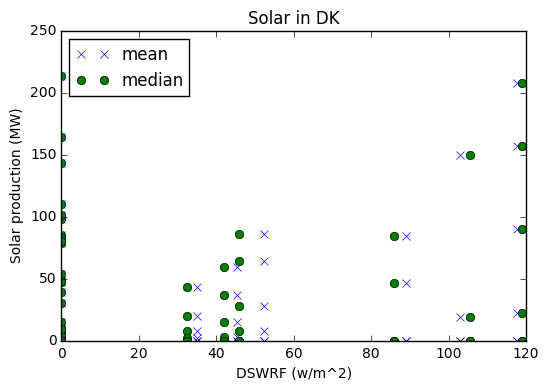

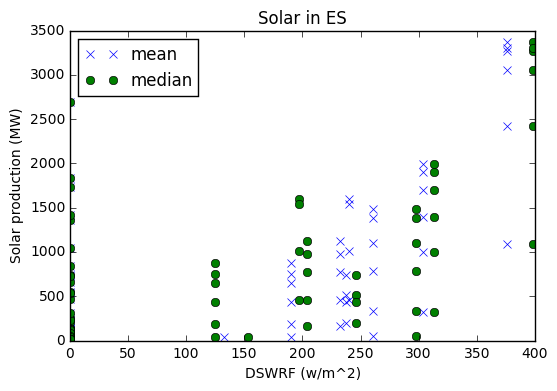

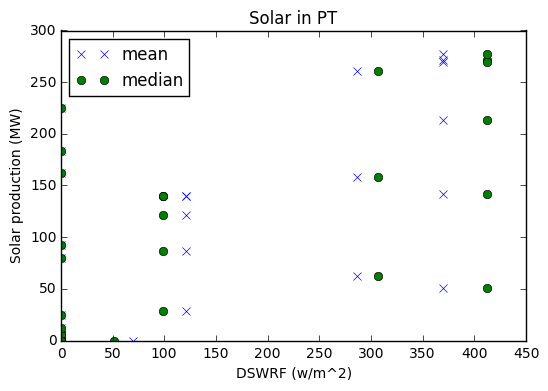

In [54]:
for country_code in country_codes:
    s_means = []
    s_medians = []
    for i in range(len(df_solar)):
        t = arrow.get(df_solar.index[i])
        s_fcast = fetch_best_solar_forecast(t)
        if not s_fcast: 
            print 'Skipping forecast at %s' % t
            continue
        s = get_solar_measurements(country_code, t, s_fcast)
        s_means.append(np.mean(s))
        s_medians.append(np.median(s))
    
    plt.figure()
    solar_prod = df_solar.loc[:, country_code]
    plt.plot(s_means, solar_prod, 'x')
    plt.plot(s_medians, solar_prod, 'o')
    plt.title('Solar in %s' % country_code)
    plt.ylabel('Solar production (MW)')
    plt.xlabel('DSWRF (w/m^2)')
    plt.legend(['mean', 'median'], loc=0)

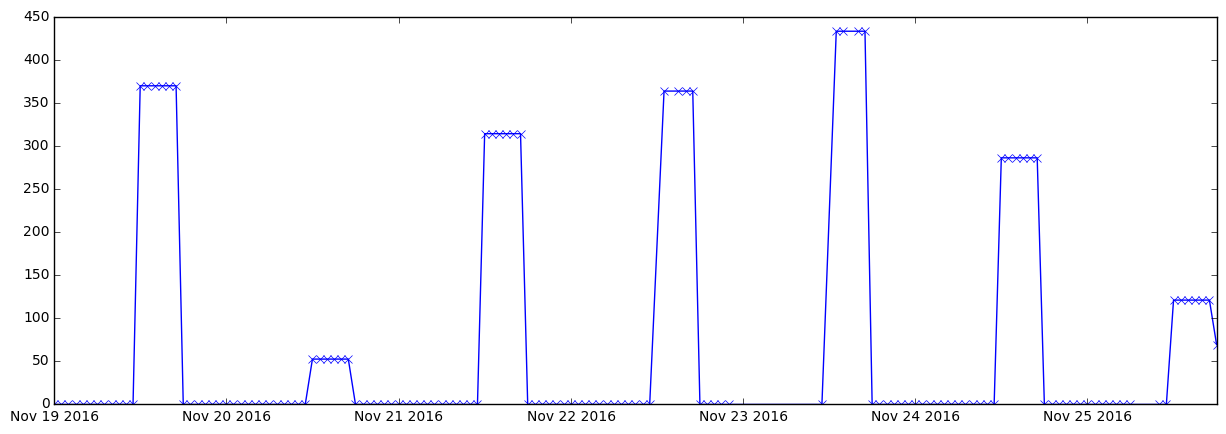

In [63]:
plt.figure(figsize=(15,5))
plt.plot(df_solar.loc[:,'PT'].index, s_means, 'x-')